In [35]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy
import matplotlib.path as mpath
from functions import compute_ivt,to_nc
from matplotlib import rc,animation
from matplotlib.animation import FuncAnimation
from IPython import display

In [37]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [38]:
cat = col.search(source_id=['NorESM2-LM'], experiment_id=['historical'], table_id=['day'], variable_id=['hus','va'], member_id=['r1i1p1f1'])
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCC,NorESM2-LM,historical,r1i1p1f1,day,hus,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-LM/historica...,NaN,20190815
1,CMIP,NCC,NorESM2-LM,historical,r1i1p1f1,day,va,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-LM/historica...,NaN,20190815


In [39]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [40]:
dataset_list = list(dset_dict.keys())
dataset_list

['CMIP.NCC.NorESM2-LM.historical.day.gn']

In [41]:
dset = dset_dict[dataset_list[0]]
dset = dset.sel(member_id='r1i1p1f1',time=slice("2000-01-01", "2014-12-31"))
dset

<xarray.Dataset>
Dimensions:    (lat: 96, lon: 144, plev: 8, time: 5475, bnds: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * plev       (plev) float64 1e+05 8.5e+04 7e+04 5e+04 ... 1e+04 5e+03 1e+03
  * time       (time) object 2000-01-01 12:00:00 ... 2014-12-31 12:00:00
    member_id  <U8 'r1i1p1f1'
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
    time_bnds  (time, bnds) object dask.array<chunksize=(5475, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    hus        (time, plev, lat, lon) float32 dask.array<chunksize=(30, 8, 96, 144), meta=np.ndarray>
    va         (time, plev, lat, lon) float32 dask.array<chunksize=(54, 8, 96, 144), meta=np.ndarray>
Attributes: (12/50)
    branch_time:               0.0
    further_info_url:          https://furtherinfo.es-doc.org/CMIP6.NCC.NorES...
    data_specs_version:        01.00.31
    cmor_version:              3.5.0
    Conventions:               CF-1.7 CMIP-6.2
    model_id:                  NorESM2-LM
    ...                        ...
    institution_id:            NCC
    run_variant:               N/A
    source_type:               AOGCM
    external_variables:        areacella
    branch_time_in_parent:     430335.0
    intake_esm_dataset_key:    CMIP.NCC.NorESM2-LM.historical.day.gn

In [42]:
vas = dset.va
hus = dset.hus
plev = dset.plev
lat_ = hus.lat
lon_ = hus.lon

In [43]:
ivt = compute_ivt(hus,vas,plev)

In [44]:
ivt

<xarray.DataArray (time: 5475, lat: 96, lon: 144)>
dask.array<mul, shape=(5475, 96, 144), dtype=float64, chunksize=(143, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time       (time) object 2000-01-01 12:00:00 ... 2014-12-31 12:00:00
    member_id  <U8 'r1i1p1f1'

In [45]:
# if we are on the southern hemisphere the poleward ivt was negative but is made positive with the following code
ivt_ns = ivt.copy() 
ivt_ns = xr.where(ivt_ns.lat<0,-ivt_ns,ivt_ns,True) # minus for southern hemisphere (positive toward the pole)
ivt_ns_pos = xr.where(ivt_ns<0,ivt_ns*0,ivt_ns,True) # negative values = not poleward
ivt_ns_pos

<xarray.DataArray 'lat' (lat: 96, time: 5475, lon: 144)>
dask.array<where, shape=(96, 5475, 144), dtype=float64, chunksize=(96, 143, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
    member_id  <U8 'r1i1p1f1'
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time       (time) object 2000-01-01 12:00:00 ... 2014-12-31 12:00:00

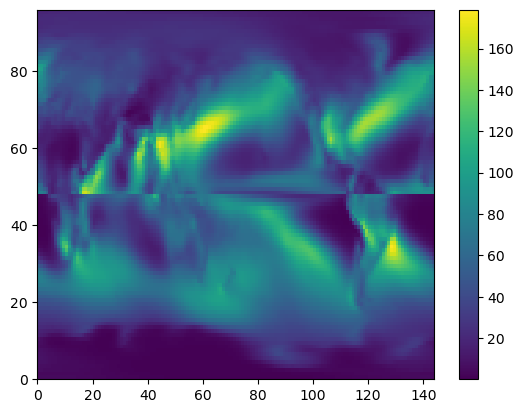

In [36]:
plt.pcolormesh(ivt_ns_pos.mean(dim='time'))
plt.colorbar()
plt.show()

In [46]:
mn = ivt_ns_pos.mean(dim='time')
mn

<xarray.DataArray 'lat' (lat: 96, lon: 144)>
dask.array<mean_agg-aggregate, shape=(96, 144), dtype=float64, chunksize=(96, 144), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
    member_id  <U8 'r1i1p1f1'
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

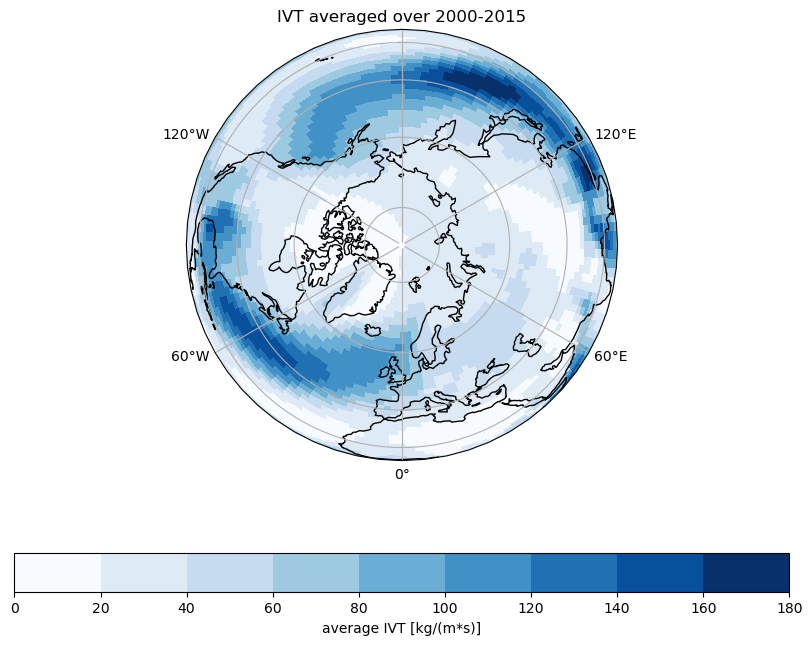

In [35]:
f,ax = plt.subplots(dpi=100, figsize =(10,8),
                    subplot_kw={'projection':ccrs.Orthographic(central_latitude=90.0)})
mn.plot.pcolormesh(
    cmap = plt.get_cmap('Blues'),ax=ax,
    cbar_kwargs={
        'label':'average IVT [kg/(m*s)]', 
        'orientation':'horizontal',
        
    },
    transform=ccrs.PlateCarree(), 
    x='lon',y='lat',
    levels = 10
)
ax.set_title('IVT averaged over 2000-2015')
ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

#ax.add_feature(cy.feature.BORDERS);

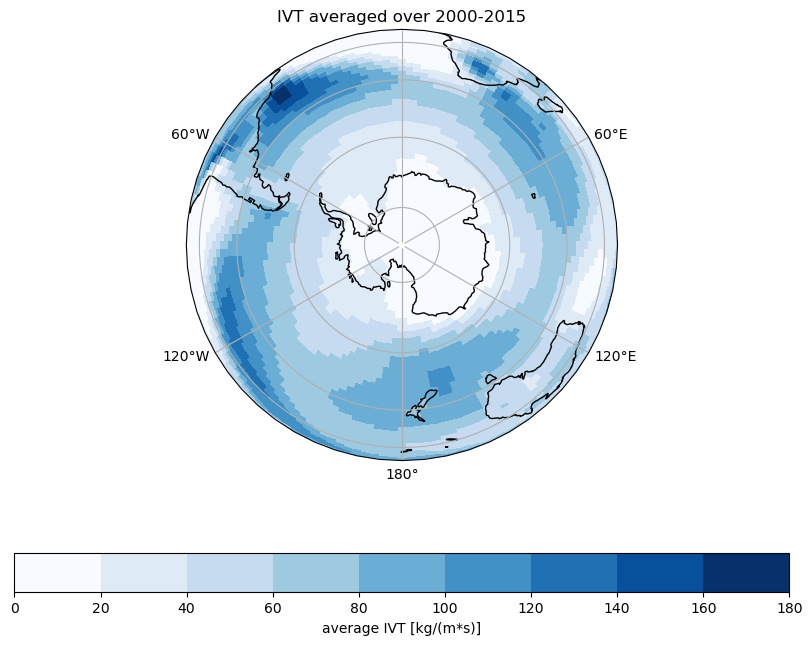

In [34]:
f,ax = plt.subplots( dpi=100, figsize =(10,8),
                    subplot_kw={'projection':ccrs.Orthographic(central_latitude=-90.0)})
mn.plot.pcolormesh(
    cmap = plt.get_cmap('Blues'),ax=ax,
    cbar_kwargs={
        'label':'average IVT [kg/(m*s)]', 
        'orientation':'horizontal',
        
    },
    transform=ccrs.PlateCarree(), 
    x='lon',y='lat',
    levels = 10
)
ax.set_title('IVT averaged over 2000-2015')
ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

In [14]:
mv = ivt_ns_pos.std(dim='time')/ivt_ns_pos.mean(dim='time')

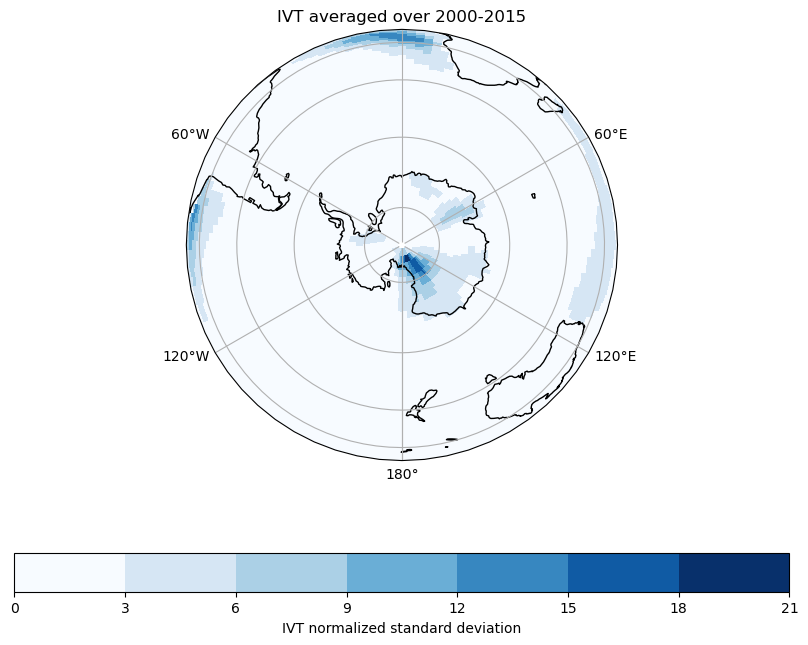

In [31]:
f,ax = plt.subplots(dpi=100, figsize =(10,8),
                    subplot_kw={'projection':ccrs.Orthographic(central_latitude=-90.0)})
mv.plot.pcolormesh(
    cmap = plt.get_cmap('Blues'),ax=ax,
    cbar_kwargs={
        'label':'IVT coefficient of variation', 
        'orientation':'horizontal',
        
    },
    transform=ccrs.PlateCarree(), 
    x='lon',y='lat',
    levels = 10
)
ax.set_title('IVT averaged over 2000-2015')
ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

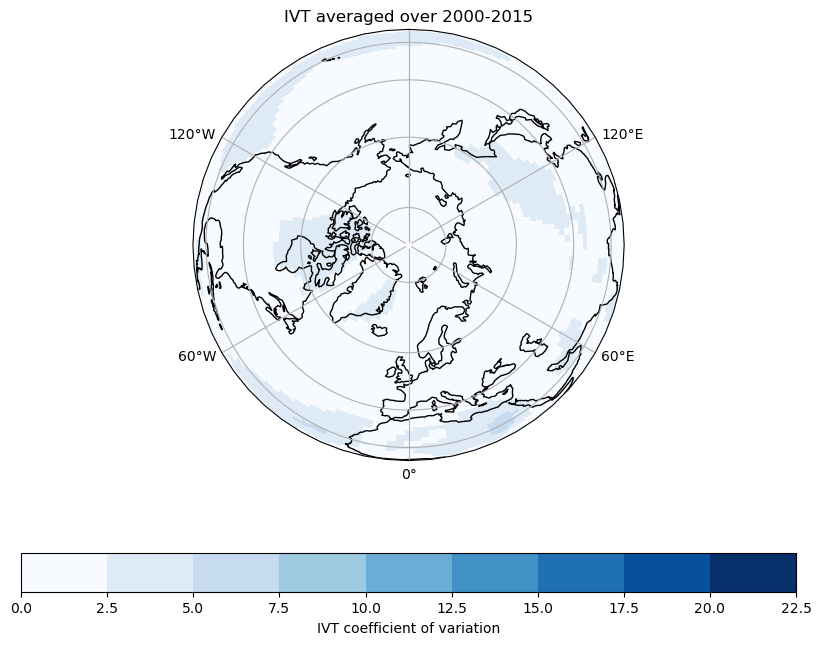

In [37]:
f,ax = plt.subplots(dpi=100, figsize =(10,8),
                    subplot_kw={'projection':ccrs.Orthographic(central_latitude=90.0)})
mv.plot.pcolormesh(
    cmap = plt.get_cmap('Blues'),ax=ax,
    cbar_kwargs={
        'label':'IVT coefficient of variation', 
        'orientation':'horizontal',
        
    },
    transform=ccrs.PlateCarree(), 
    x='lon',y='lat',
    levels = 10
)
ax.set_title('IVT averaged over 2000-2015')
ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

In [47]:
q98 = ivt_ns_pos.chunk(dict(time=-1)).quantile(0.98,'time')

In [48]:
ar = ivt_ns_pos-q98

In [70]:
ar = ar.where(ar > 0)
arn = ar.sel(lat = slice(40,90))
arn_mean = arn.mean('time')

array([[110, 110, 110, ..., 110, 110, 110],
       [110, 110, 110, ..., 110, 110, 110],
       [110, 110, 110, ..., 110, 110, 110],
       ...,
       [110, 110, 110, ..., 110, 110, 110],
       [110, 110, 110, ..., 110, 110, 110],
       [110, 110, 110, ..., 110, 110, 110]])

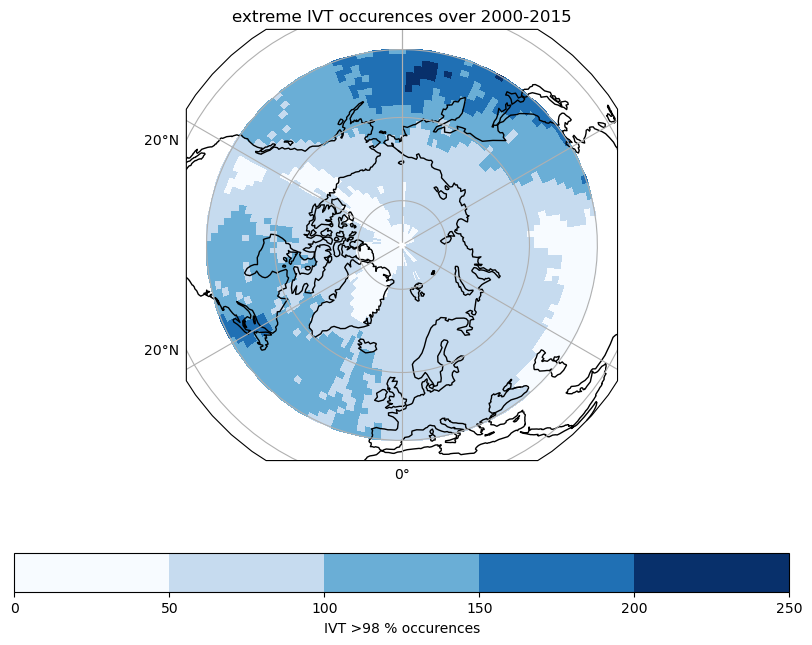

In [71]:
f,ax = plt.subplots(dpi=100, figsize =(10,8),
                    subplot_kw={'projection':ccrs.Orthographic(central_latitude=90.0)})
arn_mean.plot.pcolormesh(
    cmap = plt.get_cmap('Blues'),ax=ax,
    cbar_kwargs={
        'label':'IVT >98 %', 
        'orientation':'horizontal',
        
    },
    transform=ccrs.PlateCarree(), 
    x='lon',y='lat',
    levels = 6
)
ax.set_title('extreme IVT  over 2000-2015')
ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

In [ ]:
f,ax = plt.subplots(dpi=100, figsize =(10,8),
                    subplot_kw={'projection':ccrs.Orthographic(central_latitude=90.0)})
arn_sum.plot.pcolormesh(
    cmap = plt.get_cmap('Blues'),ax=ax,
    cbar_kwargs={
        'label':'IVT >98 % (kg/(m*s))', 
        'orientation':'horizontal',
        
    },
    transform=ccrs.PlateCarree(), 
    x='lon',y='lat',
    #levels = 6
)
ax.set_title('AR averaged over 2000-2015')
ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

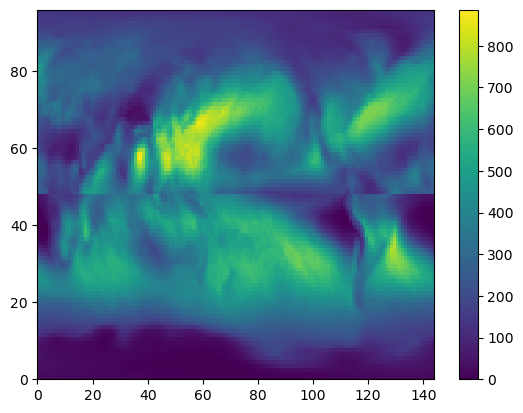

In [43]:
plt.pcolormesh(q98)
plt.colorbar()
plt.show()